In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timm

timm.__version__

'0.8.3dev0'

In [17]:
# list convnext models

timm.list_models('*convnext_pico*', pretrained=True)

['convnext_pico.d1_in1k', 'convnext_pico_ols.d1_in1k']

In [4]:
# create model

# model = timm.create_model('convnext_atto.d2_in1k', pretrained=True, in_chans=6, global_pool='', num_classes=0)
model = timm.create_model('convnext_atto.d2_in1k', pretrained=True, in_chans=6, features_only=True)
model

FeatureListNet(
  (stem_0): Conv2d(6, 40, kernel_size=(4, 4), stride=(4, 4))
  (stem_1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
  (stages_0): ConvNeXtStage(
    (downsample): Identity()
    (blocks): Sequential(
      (0): ConvNeXtBlock(
        (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
        (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
        (mlp): ConvMlp(
          (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
          (norm): Identity()
          (act): GELU()
          (drop): Dropout(p=0.0, inplace=False)
          (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (drop_path): Identity()
      )
      (1): ConvNeXtBlock(
        (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
        (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
        (mlp): ConvMlp(
          (fc1): Conv2d(40, 160, kernel_size=(1, 1)

In [5]:
import torch 

fs = model(torch.randn(1, 6, 256, 256))
for f in fs:
    print(f.shape)


torch.Size([1, 40, 64, 64])
torch.Size([1, 80, 32, 32])
torch.Size([1, 160, 16, 16])
torch.Size([1, 320, 8, 8])


In [6]:
# model2 = timm.create_model('resnet18', pretrained=True, in_chans=6, features_only=True)
# fs = model2(torch.randn(1, 6, 256, 256))
# for f in fs:
#     print(f.shape)

In [7]:
model.feature_info[-1]['num_chs']

320

In [8]:
[f['num_chs'] for f in model.feature_info]

[40, 80, 160, 320]

In [9]:
from src.dm import DataModule2 as DataModule

dm = DataModule(batch_size=4)
dm.setup()

train: 8689
test: 2773


In [10]:
x1, x2, labels = next(iter(dm.train_dataloader()))

x1.shape, x2.shape, labels.shape

(torch.Size([4, 12, 256, 256, 2]),
 torch.Size([4, 12, 256, 256, 6]),
 torch.Size([4, 256, 256]))

In [11]:
from src.models.unet_ltae_timm import UNetLTAET

hparams = {
    'encoder': 'convnext_atto.d2_in1k',
    'pretrained': True,
    'in_channels_s1': 2,
    'in_channels_s2': 6,
    'seq_len': 12,
    'n_head': 8,
}

model = UNetLTAET(hparams)

output = model(x1, x2)
output.shape

torch.Size([4, 256, 256])

In [18]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
    'encoder': 'convnext_pico.d1_in1k',
    'pretrained': True,
    'in_channels_s1': 2,
    'in_channels_s2': 6,
    'seq_len': 12,
    'n_head': 8,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetLTAET(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=500,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Downloading:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | FeatureListNet   | 8.5 M 
1 | encoder2          | FeatureListNet   | 8.5 M 
2 | decoder           | UnetDecoder      | 1.7 M 
3 | segmentation_head | SegmentationHead | 91    
4 | ltae              | LTAE             | 1.2 M 
-------------------------------------------------------
19.9 M    Trainable params
25.6 K    Non-trainable params
19.9 M    Total params
39.883    Total estimated model params size (MB)


train: 8689
test: 2773


Training: 0it [00:00, ?it/s]

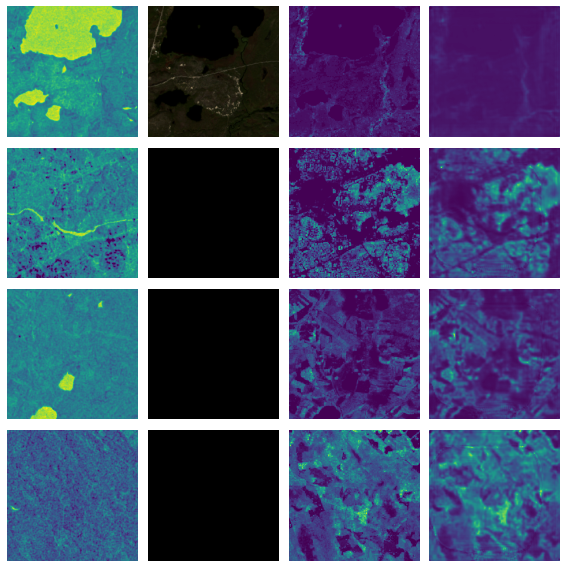

In [19]:
import matplotlib.pyplot as plt 

s1s, s2s, labels = next(iter(dm.train_dataloader(shuffle=False)))
preds = module.predict(s1s, s2s)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][...,0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0][...,:3])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()